In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [2]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"

#vineScores = "../Logs/sampled_vine_sentibank_final.csv"
vineScores = "../Logs/MVSO_fine_vine_probs.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
vineANPs = "../Logs/MVSO_fine_vine_ANPs.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

postFile = "../Logs/postsMapping.csv"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

color_features = "../Logs/vine_features_ordered.csv"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

In [3]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')
sentibank_baseline = np.loadtxt(sentibank_scores, delimiter=',')

In [4]:
print vineProbs.shape , sentibank_baseline.shape

(138256, 4342) (5000, 2089)


In [207]:
def get_ANP_ID_List(pickleList):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[5].split('_')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index):
    oldId = pickle[index].split(',')[0].split('/')[6].split('_')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[6].split('_')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index
    
def get_VID_ANP_List(pickle):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i)
        megaDict[int(postId)] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        if len(commns) >= 6:
            filteredList[entry] = megadict[entry]
    return filteredList

def readJson(path):
    f = open(path)
    data = json.loads(f.read())
    return data


In [6]:
image_list =[]
with open(sampled_img_list) as f:
    image_list = f.readlines()

true_labels = []
for line in image_list:
    label = line.split('/')[5]
    true_labels.append(label)
    
# f = open(ClassFile ,'r')
# sentibankClasses = json.load(f)
# f.close()

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

In [7]:
sentibank_probs = np.zeros(len(sentibank_baseline))
detected_labels = []
for i in range(sentibank_probs.shape[0]):
    sentibank_probs[i] = sentibank_baseline[i].max()
    detected_labels.append(str(sentibankClasses[np.argmax(sentibank_baseline[i])]))
    
print np.median(sentibank_probs), sentibank_probs.var(), sentibank_probs.mean()

0.0718716159463 0.0234088881327 0.125452709451


In [8]:
maxVecs = np.zeros(len(vineProbs))
for i in range(len(vineProbs)):
    maxVecs[i] = np.max(vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

0.0214652778476 0.0156120234169 0.000478212839106


In [205]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > (np.mean(maxVecs) + np.var(maxVecs) )):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

42985


In [206]:

vineList = readLists(vineANPs)
objList = readLists(imageNetObjs)
print curatedProbs_index[5]
print objList[1]

24
/datasets/sagarj/vineData/sampledFrames/1281860887099457536_2.jpg,label,television,


In [208]:
print vineList[0].split(',')[0].split('/')[6].split('_')[0]

1000521578741956608


In [209]:
idList, anpList = get_ANP_ID_List(vineList)

In [210]:
#print idList[1000] , anpList [1000]

In [211]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [572]:
sentiArray = []
for k in sentidict:
    sentiArray.append(sentidict[k])
print len(sentiArray)

4421


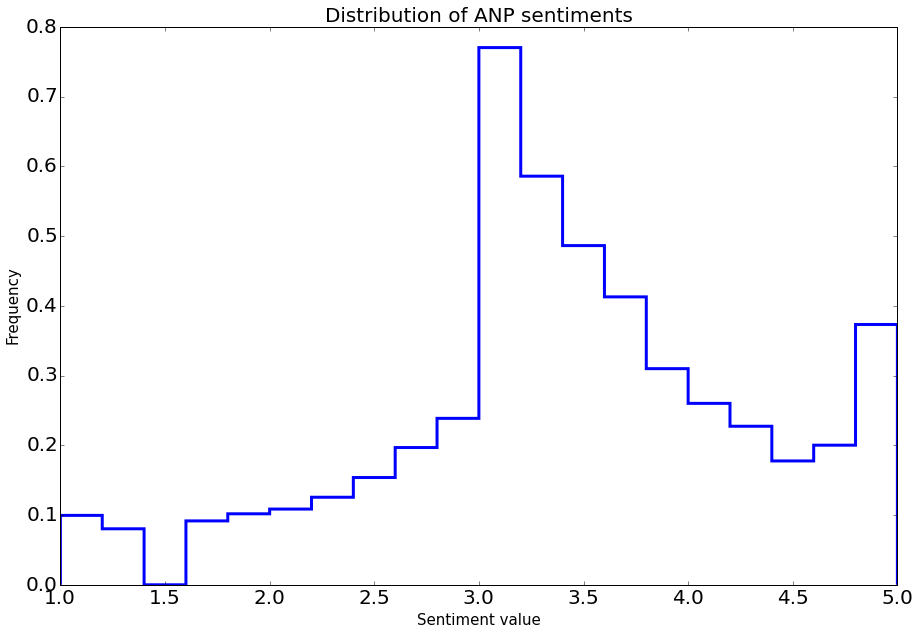

In [573]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sentiArray, 20, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of ANP sentiments", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.show()

In [213]:
# f = open('sentibankANP.csv', 'wb')
# for k,v in sentidict0.iteritems():
#     f.write(k+','+str(v)+'\n')
#     #print k , v
# f.close()

In [214]:
megaDict = get_VID_ANP_List(vineList)

138256


In [215]:
#megaDict[1281867050901532672]['indexList']

In [216]:
filteredDict = pruneMegaDict(megaDict, curatedProbs_index)

In [217]:
print len(filteredDict)

3173


In [218]:
len(megaDict)

11449

In [219]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[6].split('_')[0])
    postIds.append(i)

In [220]:
letter_counts = Counter(postIds)

In [221]:
len(letter_counts)

11449

In [222]:
#Vectors for filtered videos
senti_matrix = np.zeros((len(filteredDict),12))
print senti_matrix.shape
postList = [1]

(3173, 12)


In [223]:
i = 0
misses = 0
postIdFilteredList = []
for entry in filteredDict:
    postIdFilteredList.append(entry)
    for j in range(1,13):
        if j in filteredDict[entry]:
            senti_matrix[i][j-1] = sentidict[filteredDict[entry][j]] if (filteredDict[entry][j] in sentidict) else sentidict[filteredDict[entry][j-1]]
        else:
            senti_matrix[i][j-1] = senti_matrix[i][j-2]
            misses += 1
    i += 1
print misses

785


In [224]:
#Get all post meta data 
with open(postFile, 'rb') as f:
        lines = f.readlines()

postDict = {}
postList = []
for line in lines:
    comp = line.split(',')
    postDict[comp[0]] = comp[1]
    postList.append(comp[1])

print len(postDict) , postList[1:10]

11450 ['1233144870621925376.json\n', '1171722795202510848.json\n', '1290080547120541696.json\n', '1288686800390750208.json\n', '1137138037525221376.json\n', '1260815378305658880.json\n', '1291198489602273280.json\n', '1292323982284341248.json\n', '1267596053243674624.json\n']


In [225]:
selectedPosts = []
allPosts = []

for d in postList:
    dataRoot = "/datasets/sagarj/vineData/Dataset/Posts/" + d.strip()
    f = open(dataRoot , 'rb')
    data = json.loads(f.read())
    allPosts.append(data['data']['records'][0])

In [226]:
print len(allPosts)

11450


In [227]:
filteredPosts = dict()
for k in filteredDict:
    for post in allPosts:
        if post['postId'] == k:
            filteredPosts[k] = post
print len(filteredPosts)

3173


In [228]:
import random
rand_smpl = [ allPosts[i] for i in sorted(random.sample(xrange(len(allPosts)), len(filteredPosts))) ]
print len(rand_smpl)

allLikes = []
allReposts = []
allLoops = []
for rec in rand_smpl:
    allLikes.append(rec['likes']['count'])
    allReposts.append(rec['reposts']['count'])
    allLoops.append(rec['loops']['count'])

3173


In [229]:
print np.min(allLikes) , np.max(allLikes) , np.min(allReposts) , np.max(allReposts)

23 1064789 0 782875


In [230]:
filLikes = []
filReposts = []
filLoops = []
filPosts = []
for k in filteredPosts:
    filLikes.append(np.log(filteredPosts[k]['likes']['count']+1))
    filReposts.append(np.log(filteredPosts[k]['reposts']['count']+1))
    filLoops.append(np.log(filteredPosts[k]['loops']['count']+1))
    filPosts.append(filteredPosts[k])

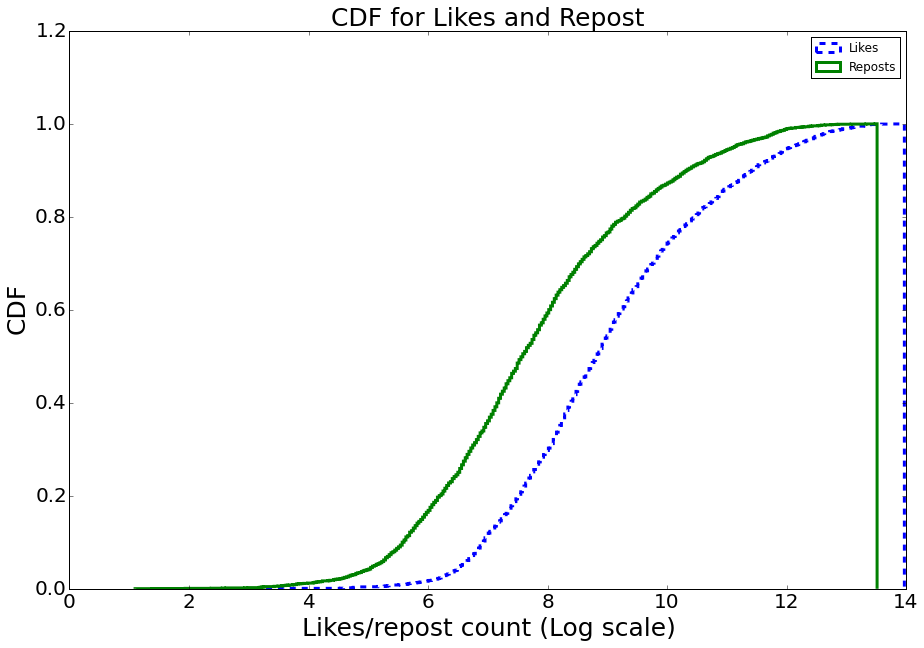

In [231]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(filLikes, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(filReposts, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.title("CDF for Likes and Repost", fontsize = 25)
plt.xlabel("Likes/repost count (Log scale)",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes' , 'Reposts'])
plt.show()


In [232]:
sortedWRTLikesPosts = [x for (y,x) in sorted(zip(filLikes,filPosts))]
sortedWRTRepostsPosts = [x for (y,x) in sorted(zip(filReposts,filPosts))]

In [233]:
print np.min(filLikes) , np.max(filLikes) , np.min(filReposts) , np.max(filReposts)

3.09104245336 13.9662373831 1.09861228867 13.5099075268


In [234]:
print np.median(filLikes)
print np.median(filReposts)
print np.median(np.log(allLikes))
print np.median(np.log(allReposts))

8.83389994291
7.5903469456
8.90585118121
7.69530313496


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [235]:
print np.corrcoef(filReposts,filLoops)
print np.corrcoef(filLikes,filLoops)
print np.corrcoef(filReposts,filLikes)

[[ 1.         0.9081766]
 [ 0.9081766  1.       ]]
[[ 1.          0.94994312]
 [ 0.94994312  1.        ]]
[[ 1.         0.9701725]
 [ 0.9701725  1.       ]]


In [236]:
from sklearn.svm import LinearSVR
clf = LinearSVR()

clf.fit(senti_matrix, filReposts) 
print clf.coef_

[ 0.05406254 -0.01790918 -0.05023173 -0.0611914   0.10153948 -0.01233759
  0.05839354 -0.04356507 -0.02425901  0.02019725 -0.03739689  0.07773231]


In [439]:
print senti_matrix[:100]

[[ 4.4  4.4  4.4 ...,  4.4  4.4  4.4]
 [ 2.4  2.4  2.4 ...,  2.4  2.4  2.4]
 [ 4.2  4.   1.4 ...,  4.   1.4  4. ]
 ..., 
 [ 4.4  4.4  4.4 ...,  4.4  4.4  4.4]
 [ 2.2  2.2  3.6 ...,  2.2  4.4  4.4]
 [ 2.6  2.6  2.6 ...,  3.4  2.2  2.6]]


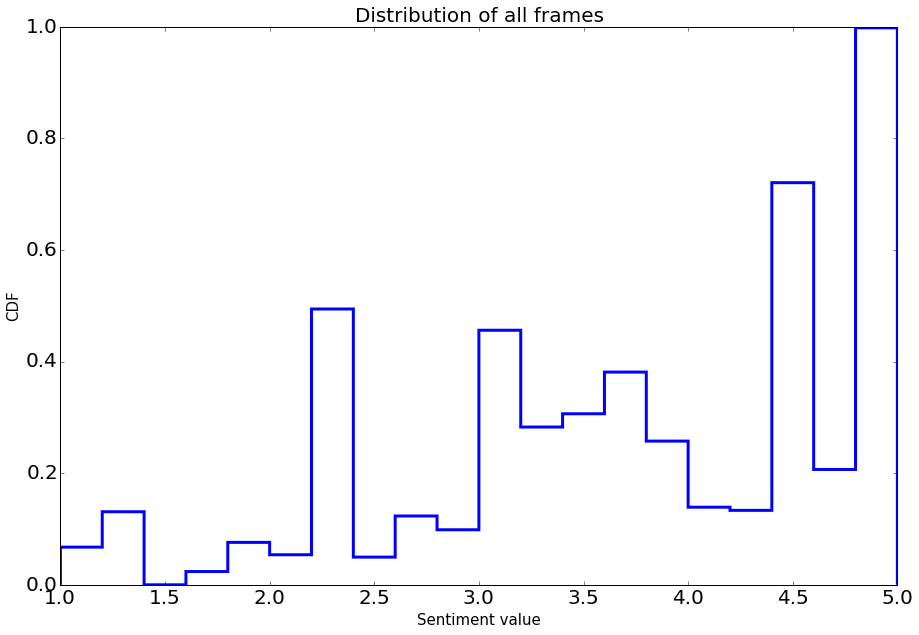

In [535]:
senti_vector = np.reshape(senti_matrix, senti_matrix.shape[0]*senti_matrix.shape[1])
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(senti_vector, 20, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of all frames", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

In [551]:
maxGraph = np.zeros(senti_matrix.shape[1])
minGraph = np.zeros(senti_matrix.shape[1])
varMaxGraph = np.zeros(senti_matrix.shape[1])
varMinGraph = np.zeros(senti_matrix.shape[1])
differenceList = []
id1 = []
id2 = []
for i in range(len(senti_matrix)):
    a = max(senti_matrix[i])
    b = min(senti_matrix[i])
    median_sent = np.median(senti_matrix[i])
    diff = a - b
    
    diff2 = a - median_sent
    if diff > 0.5:
        ind1 = senti_matrix[i].tolist().index(a)
        if ind1 < 2:
             id1.append(i)
        maxGraph[ind1] += 1
        ind2 = senti_matrix[i].tolist().index(b)
        if ind2 < 2:
             id2.append(i)
        minGraph[ind2] += 1
        differenceList.append(diff)
    
    
maxGraph = maxGraph/senti_matrix.shape[0]
minGraph = minGraph/senti_matrix.shape[0]
print maxGraph
print minGraph
print senti_matrix.shape
print np.sum(maxGraph),np.sum(minGraph)
print len(id1) , len(id2)

[ 0.2306965   0.091081    0.07532304  0.06177119  0.06082572  0.05294674
  0.04569808  0.04002521  0.03876458  0.04191617  0.03025528  0.02899464]
[ 0.21021116  0.09171131  0.07217145  0.06366215  0.05704381  0.04758903
  0.05074062  0.04695871  0.04412228  0.0378191   0.04380712  0.03246139]
(3173, 12)
0.798298140561 0.798298140561
1021 958


In [553]:
c3 = list(set(id1).intersection(id2))
len(c3)

219

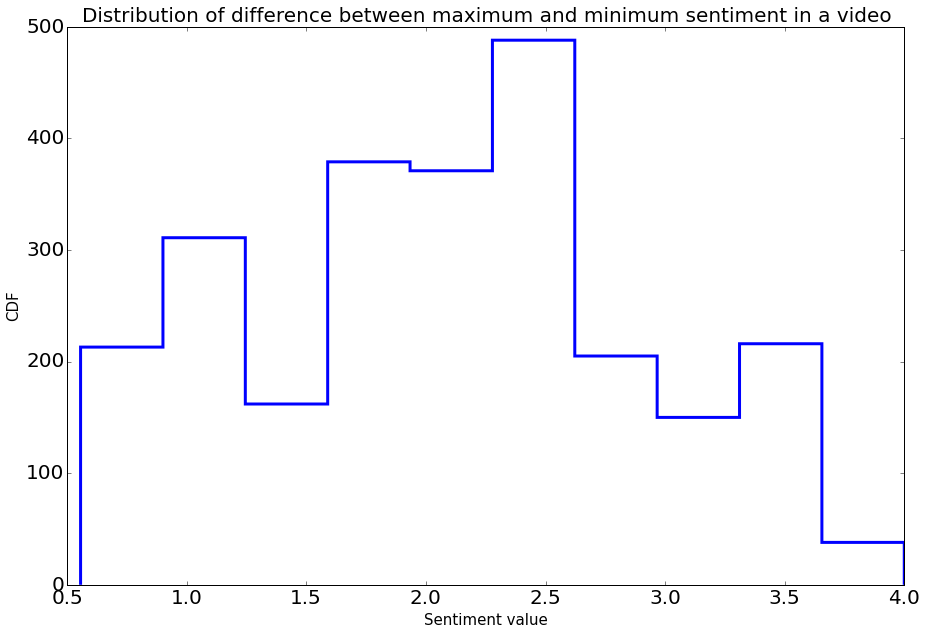

In [532]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
n, bins, patches = plt.hist(differenceList, 10, normed=0,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of difference between maximum and minimum sentiment in a video", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

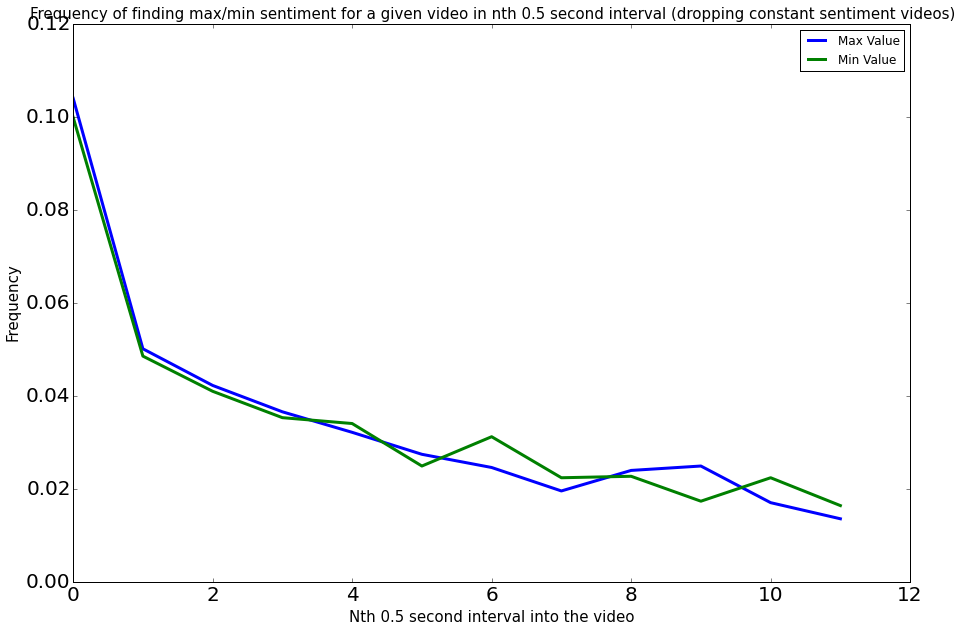

In [528]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Frequency of finding max/min sentiment for a given video in nth 0.5 second interval (dropping constant sentiment videos)", fontsize = 15)
plt.xlabel("Nth 0.5 second interval into the video",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.plot(maxGraph,linewidth = 3.0)
plt.plot(minGraph,linewidth = 3.0)
plt.legend(['Max Value', 'Min Value'   
           ])
plt.show()

In [468]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [241]:
centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

In [242]:
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

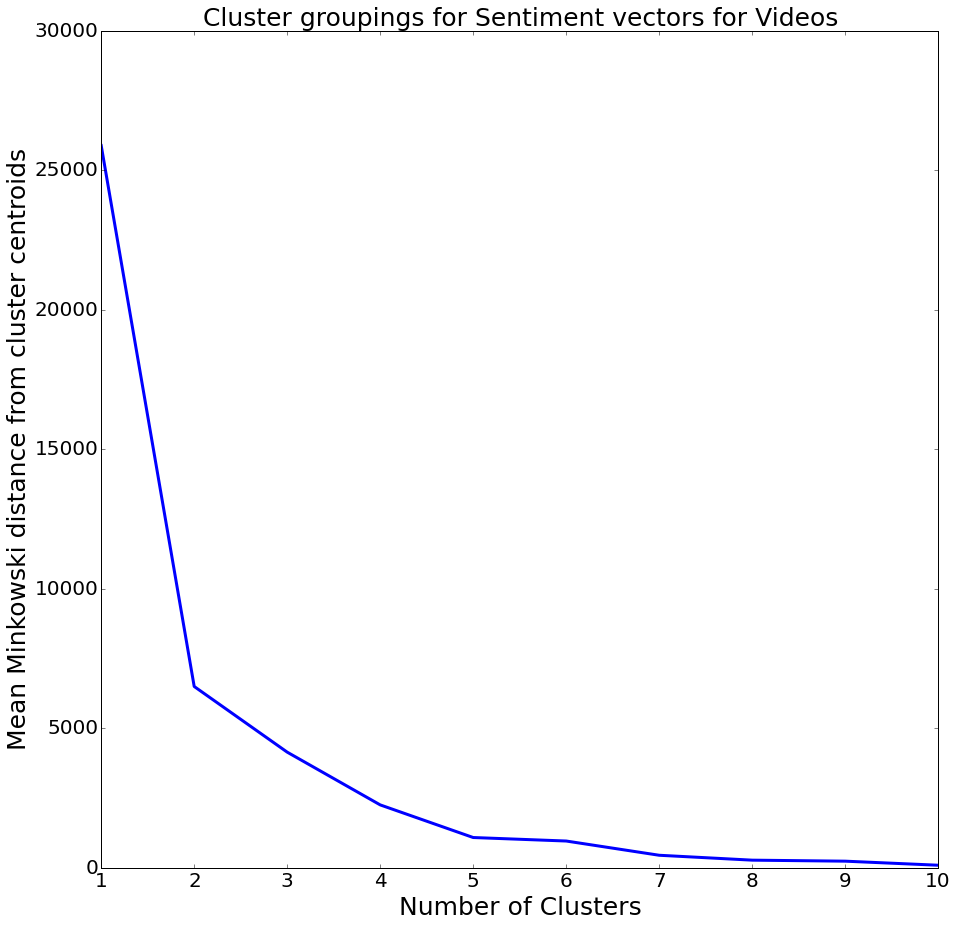

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.title("Cluster groupings for Sentiment vectors for Videos", fontsize = 25)
plt.show()

In [244]:
print SSE_values

[ 25887.98949763   6498.80038582   4145.36535135   2254.83436123
   1085.09630647    959.7368831     449.43359274    273.96548114
    237.59132033     92.18753409     38.10826461]


In [245]:
U, s, V = np.linalg.svd(senti_matrix, full_matrices=False)

In [246]:
print U.shape,  np.diag(s).shape, V.shape
print s

(3173, 12) (12, 12) (12, 12)
[ 721.04352533   62.83361298   49.68192699   46.0622449    40.3171497
   39.57280596   37.50252646   35.87788377   34.34220174   33.80151533
   33.07658414   32.18794828]


In [247]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(senti_matrix)

PCA(copy=True, n_components=10, whiten=False)

In [259]:
variances = pca.explained_variance_ratio_
print variances[:5]

[ 0.53070068  0.09816306  0.06101944  0.05283938  0.0404407 ]


In [319]:
principals=  2.5 + 5*pca.components_
print principals[:5]

[[ 2.23704618  2.22881984  2.21604544  2.20328704  2.20819753  2.20004924
   2.20137079  2.1979641   2.20478261  2.21160377  2.20741192  2.22216887]
 [ 2.86748749  2.87623114  2.84395207  2.78453553  2.70557352  2.54633946
   2.42981377  2.3326202   2.2255564   2.16258079  2.13235401  2.15006419]
 [ 2.7954158   2.84330117  2.66725572  2.4087841   2.25034219  2.10340917
   2.06733163  2.20063718  2.41357981  2.71094881  2.82350078  2.82484622]
 [ 2.27715897  2.27027819  2.45285917  2.7585222   2.90951519  2.77540765
   2.37418863  2.11161892  2.04877202  2.38105736  2.76527367  2.86078967]
 [ 2.80169213  2.56927915  2.40272088  2.22819913  2.18280952  2.58019482
   3.00038284  2.6521366   2.0720663   2.13351593  2.56749795  2.84391856]]


In [250]:
S = np.diag(s)
Mhat = np.dot(U, np.dot(S, V.T))
print Mhat.shape

(3173, 12)


In [251]:
print "Using all PCs, MSE = %.6G" %(np.mean((senti_matrix - Mhat)**2)/len(senti_matrix))

Using all PCs, MSE = 0.00483337


In [252]:
Mhat2 = np.dot(U[:, :1], np.dot(S[:1, :1], V[:,:1].T))
print Mhat2.shape
print "Using first 20 PCs, MSE = %.6G" %(np.mean((senti_matrix - Mhat2)**2)/len(senti_matrix))

(3173, 12)
Using first 20 PCs, MSE = 0.00473673


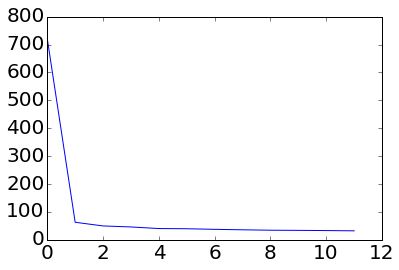

In [253]:
norms = np.linalg.norm(Modes,axis=1)

indexlist = np.argsort(np.linalg.norm(Modes,axis=1))
sorted_modes = Modes[indexlist]
norms = np.linalg.norm(sorted_modes,axis=1)
plt.plot(s)
plt.show()

In [254]:
#print sorted_modes[:3]

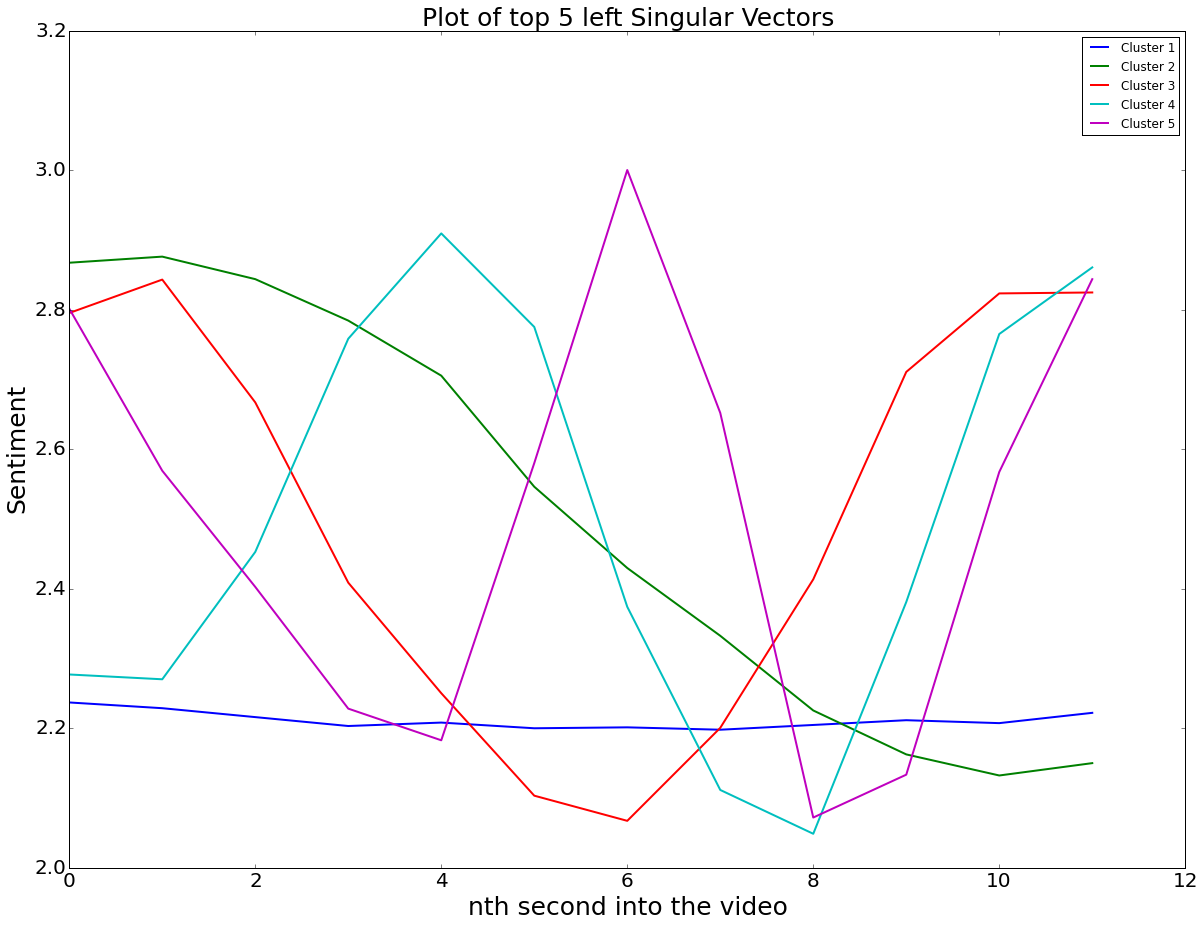

In [320]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Plot of top 5 left Singular Vectors", fontsize = 25)
plt.plot(principals[0], linewidth = 2.0)
plt.plot(principals[1], linewidth = 2.0)
plt.plot(principals[2], linewidth = 2.0)
plt.plot(principals[3], linewidth = 2.0)
plt.plot(principals[4], linewidth = 2.0 )
#plt.plot(principals[5], linewidth = 2.0 )
#plt.plot(principals[6], linewidth = 2.0 )
#plt.plot(sorted_modes[7,1:], linewidth = 2.0 )
#plt.plot(principals[8,1:], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [406]:
import math
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def topNColliniear(basis , vectors , topN):
    ang = []
    for vec in vectors:
        ang.append(angle_between(vec , basis))
    indexes = np.argsort(ang)
    print ang[indexes[0]],ang[indexes[-1]]
    print indexes[:topN]
    #returns the top N indexes with least angular value
    return indexes[:topN] , vectors[indexes[:topN]]

def getANPs(postDict , posts):
    ANP_list = []
    ids = [i['postId'] for i in posts]
    for postid in ids:
        ANP_list.append(postDict[postid])
    return ANP_list

def filterCluster(postids , posts , postDict, indexList):
    plist = []
    ANP_list = []
    ids = [postids[i] for i in indexList ]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list


In [407]:
index1 , topSentis1 = topNColliniear(principals[0], senti_matrix , 5) 
videosBasis1 , ANP1  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index1)

index2 , topSentis2 = topNColliniear(principals[1], senti_matrix , 5) 
videosBasis2 , ANP2  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index2)

index3 , topSentis3 = topNColliniear(principals[2], senti_matrix , 5) 
videosBasis3 , ANP3  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index3)

index4 , topSentis4 = topNColliniear(principals[3], senti_matrix , 5) 
videosBasis4 , ANP4  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index4)

index5 , topSentis5 = topNColliniear(principals[4], senti_matrix , 10) 
videosBasis5 , ANP5  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index5)

0.0345271770882 0.628781312687
[2853 1095  108 1618 2944]
0.194924956432 0.9889919232
[1131 2098 2855  420 1001]
0.248927724523 0.936479554706
[2375 1919 1297 2369 3067]
0.231458939779 0.956614455251
[  60  303 3108 2636  128]
0.320343671012 0.932241621939
[ 975  998 1656 1029  394 3159 1843 2043 1872 2352]


In [402]:
print (180/3.142)*0.034

1.94780394653


/datasets/sagarj/vineData/Dataset/fineSamples/1292666752152788992_6.jpg,floating_candles,0.0515294,giant_bubbles,0.0127123,extra_action,0.0108994,orthodox_wedding,0.0107923,rotten_sound,0.00890433
11449


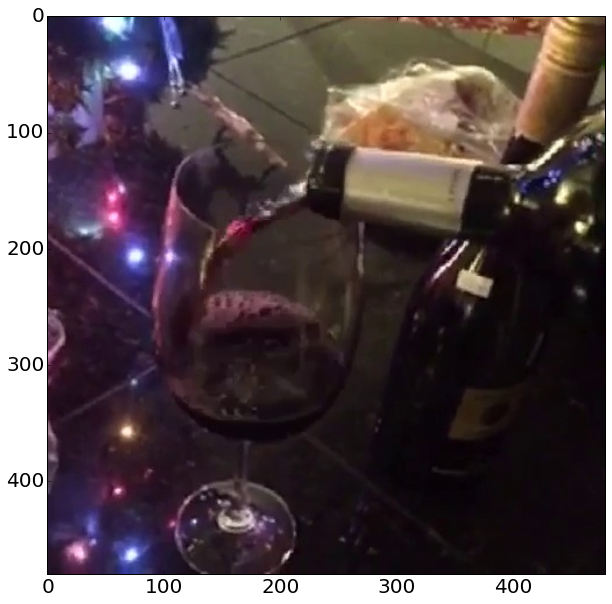

In [562]:
num = 122189
print vineList[num]
#print objList[num]
print len(megaDict)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
img = cv2.imread(vineList[num].split(',')[0],1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [400]:
import io
import base64
from IPython.display import HTML

num = 9
url = videosBasis5[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  videosBasis5[num]['videoDashUrl']
#print videosBasis1[num]
#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
#print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://v.cdn.vine.co/r/videos_dashhd/50BF95B8C01292647683936661504_14ef67aeda3.3.2.mp4?versionId=d9Sg31a.aamCG_nAeEh9c80TECi7HRmW


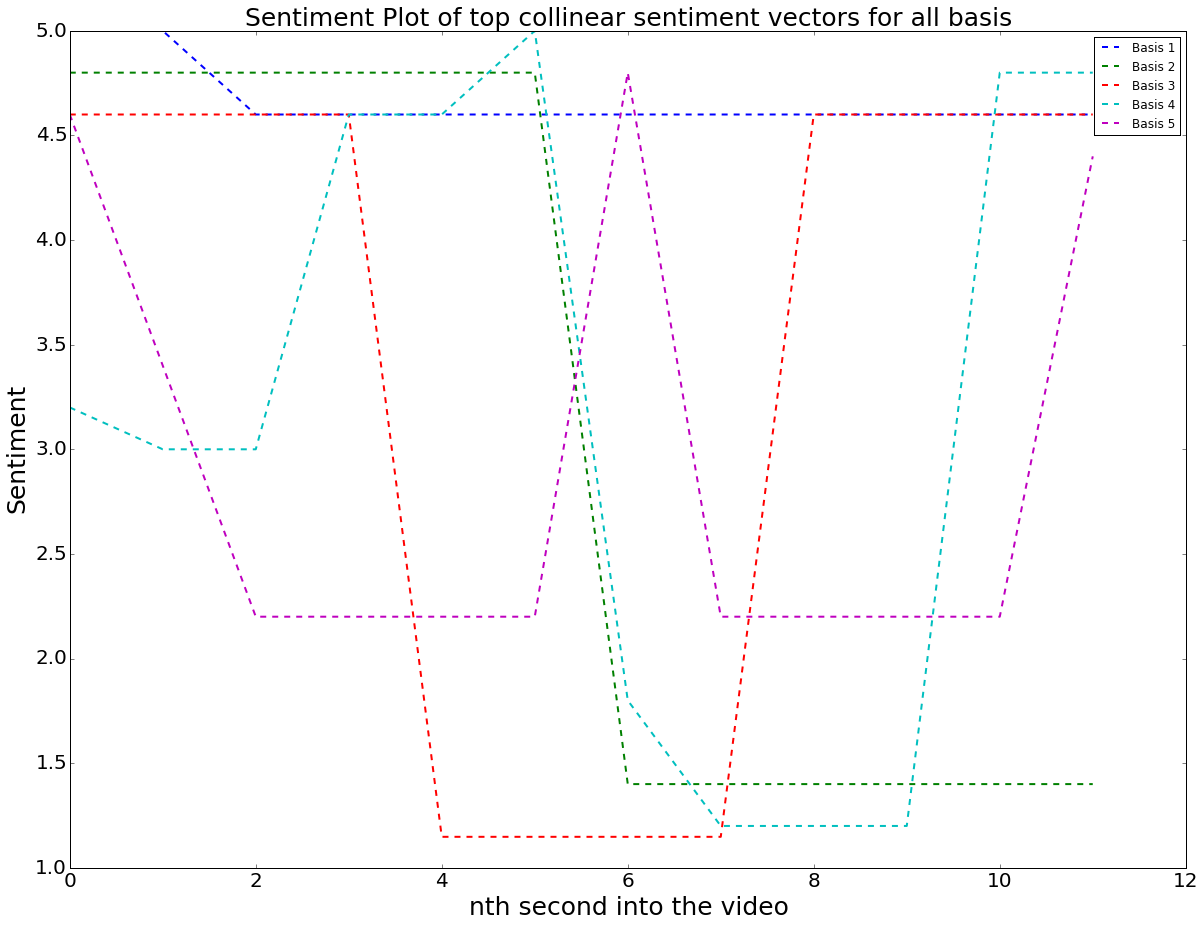

In [414]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment Plot of top collinear sentiment vectors for all basis", fontsize = 25)
plt.plot(topSentis1[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis2[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis3[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis4[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis5[0], linewidth = 2.0 , linestyle='dashed')

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Basis 1', 'Basis 2' , 'Basis 3' 
            ,'Basis 4'
            ,'Basis 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [415]:
centroid_final,_ = kmeans(senti_matrix,5)
idx_final,_ = vq(senti_matrix,centroid_final)

In [416]:
vecs1 = senti_matrix[idx_final==0,:]
vecs2 = senti_matrix[idx_final==1,:]
vecs3 = senti_matrix[idx_final==2,:]
vecs4 = senti_matrix[idx_final==3,:]
vecs5 = senti_matrix[idx_final==4,:]
vecs6 = senti_matrix[idx_final==5,:]
vecs7 = senti_matrix[idx_final==6,:]
#senti_matrix[idx_final==0]

In [417]:
print len(vecs1)
print len(vecs2)
print len(vecs3)
print len(vecs4)
print len(vecs5)
print len(vecs6)
print len(vecs7)

866
909
422
316
660
0
0


In [418]:
print centroid_final

[[ 3.1509328   3.13448276  3.08545756  3.06867595  3.11396331  3.06034041
   3.07068523  3.08046861  3.08500673  3.13052397  3.0702344   3.11908036]
 [ 4.45835141  4.45690642  4.48904439  4.51566654  4.50849764  4.49817044
   4.46537243  4.50391049  4.49741077  4.49616284  4.47315793  4.44537958]
 [ 4.18436494  4.20842934  4.21085014  4.17834032  3.99874265  3.92612144
   3.75227397  3.47030188  3.32369688  3.16622767  3.06954521  3.18602787]
 [ 2.39364654  2.29760833  2.25332914  2.12862098  2.12686222  2.107102
   2.10330453  2.05300051  2.17719085  2.17102605  2.1525073   2.25377313]
 [ 3.44162569  3.43805175  3.4583131   3.48549643  3.58352333  3.7099198
   3.8085582   3.84075889  3.96224336  4.02530149  4.05530383  4.02293337]]


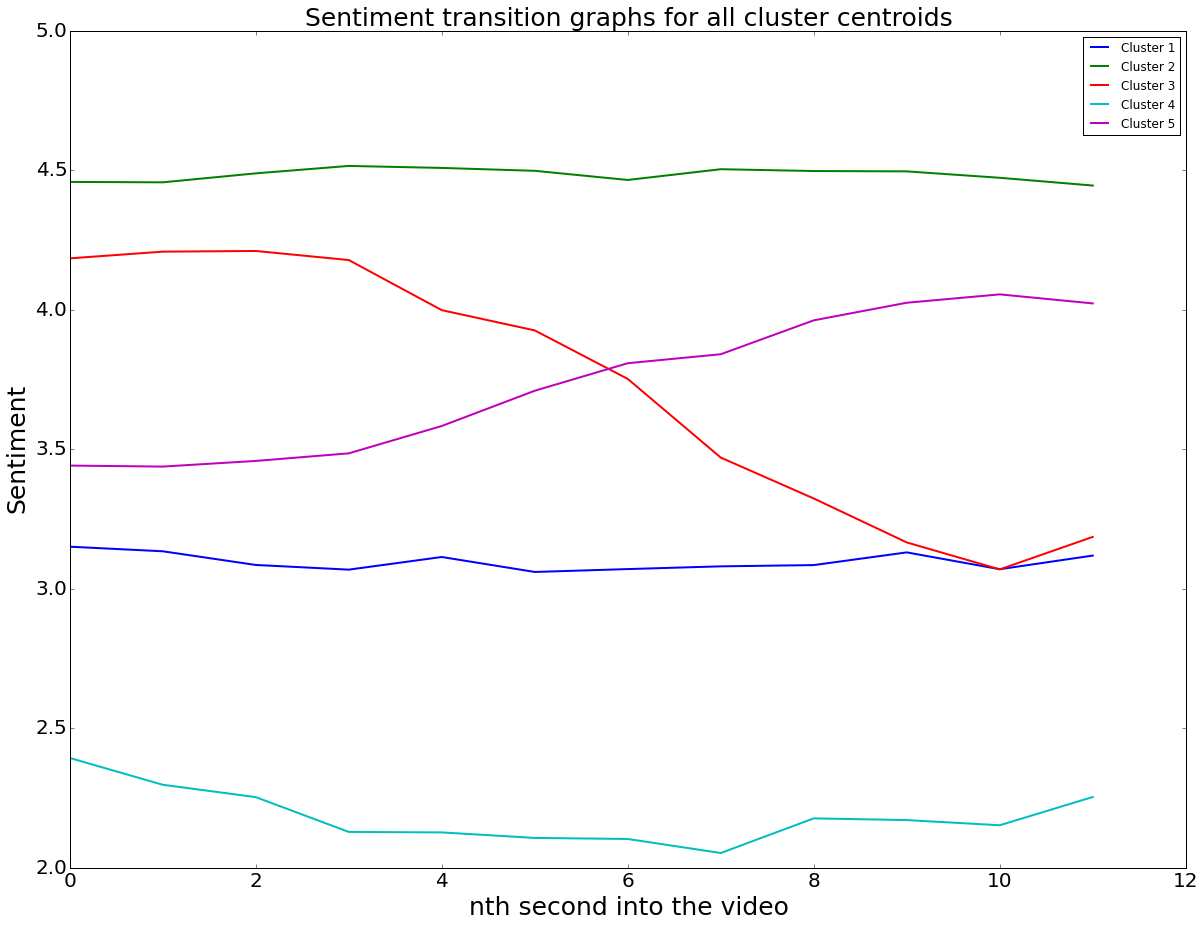

In [419]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(centroid_final[0], linewidth = 2.0)
plt.plot(centroid_final[1], linewidth = 2.0)
plt.plot(centroid_final[2], linewidth = 2.0)
plt.plot(centroid_final[3], linewidth = 2.0)
plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [424]:
index1_clusters , topSentis1_clusters = topNColliniear(centroid_final[0], senti_matrix , 5) 
videosBasis1_clusters , ANP1_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index1_clusters)

index2_clusters , topSentis2_clusters = topNColliniear(centroid_final[1], senti_matrix , 5) 
videosBasis2_clusters , ANP2_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index2_clusters)

index3_clusters , topSentis3_clusters = topNColliniear(centroid_final[2], senti_matrix , 5) 
videosBasis3_clusters , ANP3_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index3_clusters)

index4_clusters , topSentis4_clusters = topNColliniear(centroid_final[3], senti_matrix , 5) 
videosBasis4_clusters , ANP4_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index4_clusters)

index5_clusters , topSentis5_clusters = topNColliniear(centroid_final[4], senti_matrix , 5) 
videosBasis5_clusters , ANP5_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index5_clusters)

0.00946520045602 0.668654800297
[1968 1442 1444 2638  469]
0.00494556159023 0.679642905211
[2667 1444 1504  157 1526]
0.0429465876866 0.682178519766
[2994 1449 1447 1915 1482]
0.0257545368573 0.643846377937
[2944  108 2853 1253 1116]
0.015736844691 0.697377273876
[ 885 1671 2317 2509  798]


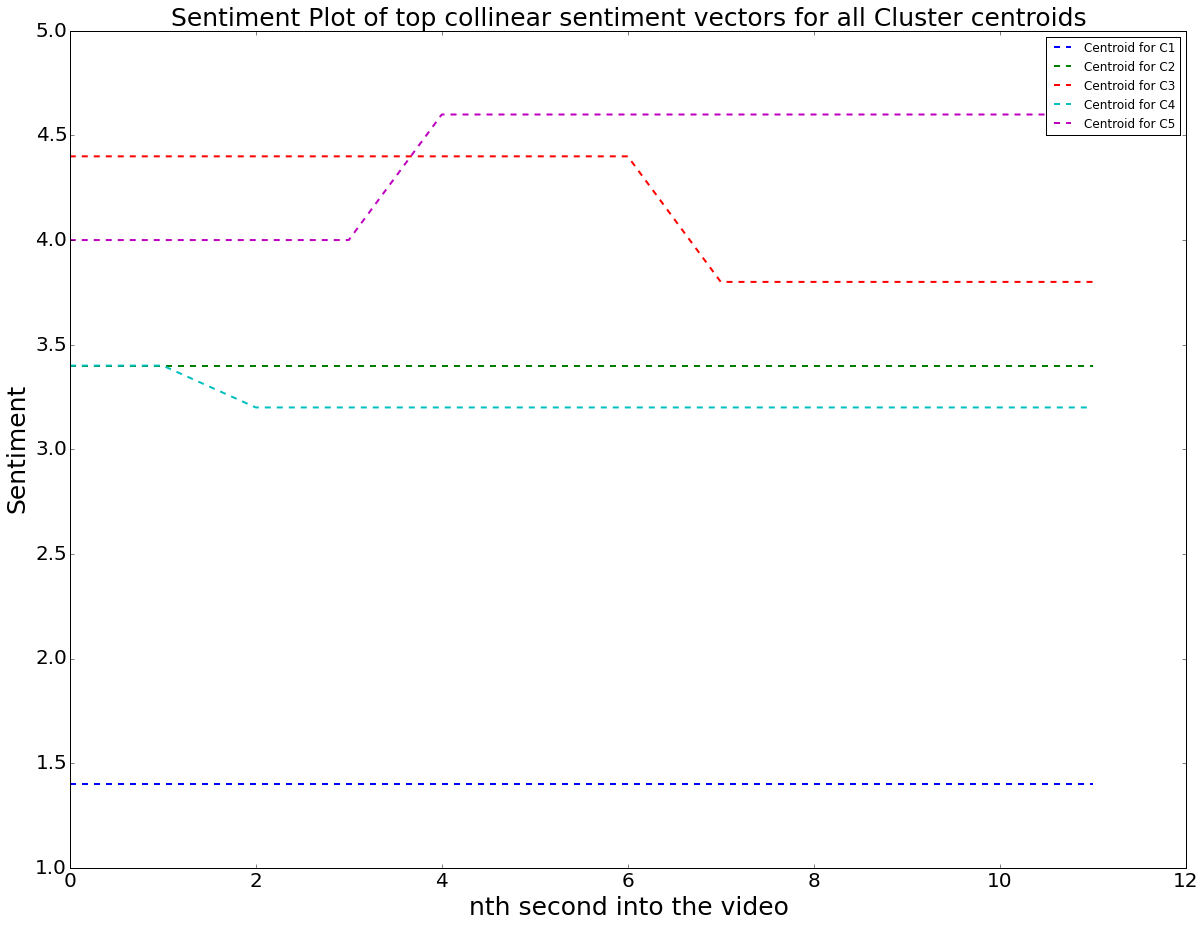

In [425]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment Plot of top collinear sentiment vectors for all Cluster centroids", fontsize = 25)
plt.plot(topSentis1_clusters[4], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis2_clusters[4], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis3_clusters[4], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis4_clusters[4], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis5_clusters[4], linewidth = 2.0 , linestyle='dashed')

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Centroid for C1', 'Centroid for C2' , 'Centroid for C3' 
            ,'Centroid for C4'
            ,'Centroid for C5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [92]:
def filterCluster(postids , posts , postDict, clusterMems , clusterId ):
    plist = []
    ANP_list = []
    selective = clusterMems == clusterId
    ids = [i for (i, v) in zip(postids, selective) if v]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list

def likesRepostsLoops(cluster):
    likes = np.zeros(len(cluster))
    reposts = np.zeros(len(cluster))
    loops = np.zeros(len(cluster))
    for i in range(len(cluster)):
        likes[i] = np.log(cluster[i]['likes']['count']+1)
        reposts[i] = np.log(cluster[i]['reposts']['count']+1)
        loops[i] = np.log(cluster[i]['loops']['count']+1)
    return likes, reposts, loops


In [93]:
cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,0)
print len(cluster1)
cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,1)
print len(cluster2)
cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,2)
print len(cluster3)
cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,3)
print len(cluster4)
cluster5 , ANP_cluster5 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,4)
print len(cluster5)

434
1301
1123
820
1388


In [94]:
likesC1 , repostsC1 , loopsC1 = likesRepostsLoops(cluster1)
likesC2 , repostsC2 , loopsC2 = likesRepostsLoops(cluster2)
likesC3 , repostsC3 , loopsC3 = likesRepostsLoops(cluster3)
likesC4 , repostsC4 , loopsC4 = likesRepostsLoops(cluster4)
likesC5 , repostsC5 , loopsC5 = likesRepostsLoops(cluster5)

In [126]:
likesC1 = likesC1/len(senti_matrix)
likesC2 = likesC2/len(senti_matrix)
likesC3 = likesC3/len(senti_matrix)
likesC4 = likesC4/len(senti_matrix)
likesC5 = likesC1/len(senti_matrix)


In [127]:
c1 = np.random.choice(len(likesC1), 300)
sampledLikesC1 = likesC1[c1]

c2 = np.random.choice(len(likesC2), 300)
sampledLikesC2 = likesC2[c2]

c3 = np.random.choice(len(likesC3), 300)
sampledLikesC3 = likesC3[c3]

c4 = np.random.choice(len(likesC4), 300)
sampledLikesC4 = likesC4[c4]

c5 = np.random.choice(len(likesC5), 300)
sampledLikesC5 = likesC5[c5]


In [128]:
print "Numbers for Cluster C1: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC1),np.mean(repostsC1),np.median(sampledLikesC1),np.mean(sampledLikesC1),np.median(loopsC1),np.mean(loopsC1))

print "Numbers for Cluster C2: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC2),np.mean(repostsC2),np.median(sampledLikesC2),np.mean(sampledLikesC2),np.median(loopsC2),np.mean(loopsC2))

print "Numbers for Cluster C3: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC3),np.mean(repostsC3),np.median(sampledLikesC3),np.mean(sampledLikesC3),np.median(loopsC3),np.mean(loopsC3))

print "Numbers for Cluster C4: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC4),np.mean(repostsC4),np.median(sampledLikesC4),np.mean(sampledLikesC4),np.median(loopsC4),np.mean(loopsC4))

print "Numbers for Cluster C5: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC5),np.mean(repostsC5),np.median(sampledLikesC5),np.mean(sampledLikesC5),np.median(loopsC5),np.mean(loopsC5))

Numbers for Cluster C1: Median Reposts: 7.532353 , Mean Reposts: 7.754815 , Median Likes: 0.001694 , Mean Likes: 0.001744 , Median Loops: 12.227239 , Mean Loops 12.536720
Numbers for Cluster C2: Median Reposts: 7.533694 , Mean Reposts: 7.635352 , Median Likes: 0.001725 , Mean Likes: 0.001759 , Median Loops: 12.382355 , Mean Loops 12.454450
Numbers for Cluster C3: Median Reposts: 7.747165 , Mean Reposts: 7.842195 , Median Likes: 0.001744 , Mean Likes: 0.001770 , Median Loops: 12.644782 , Mean Loops 12.835277
Numbers for Cluster C4: Median Reposts: 7.732801 , Mean Reposts: 7.902514 , Median Likes: 0.001741 , Mean Likes: 0.001805 , Median Loops: 12.602346 , Mean Loops 12.833081
Numbers for Cluster C5: Median Reposts: 7.587564 , Mean Reposts: 7.821379 , Median Likes: 0.000000 , Mean Likes: 0.000000 , Median Loops: 12.538804 , Mean Loops 12.818789


In [129]:
clf = LinearSVR()

clf.fit(vecs3, repostsC3) 
print clf.coef_

[ 0.02470027  0.02587459  0.27477997  0.01161148  0.12355322  0.04034576
  0.03020611  0.05442655  0.00744294  0.15960857  0.06508665  0.06072358]


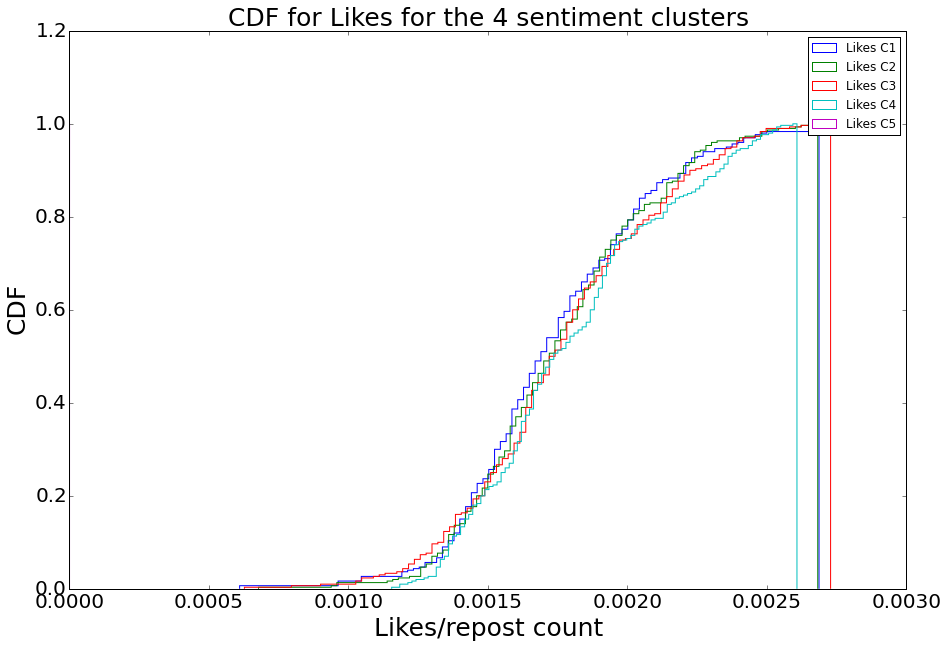

In [130]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledLikesC1, 100, normed=1,histtype='step', cumulative=True,linewidth = 1.0)
plt.hist(sampledLikesC2, 100, normed=1,histtype='step', cumulative=True,linewidth = 1.0)
plt.hist(sampledLikesC3, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledLikesC4, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledLikesC5, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.title("CDF for Likes for the 4 sentiment clusters ", fontsize = 25)
plt.xlabel("Likes/repost count",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes C1', 'Likes C2' , 'Likes C3' , 'Likes C4' , 'Likes C5'])
plt.show()

In [131]:

def plotDist(RV, samples, b):
    N = samples 
    n = b
    s = np.random.normal(size=N)   # generate your data sample with N elements
    p1, x1 = np.histogram(RV, bins=n) # bin it into n = N/10 bins
    xs1 = x1[:-1] + (x1[1] - x1[0])/2
    f1 = UnivariateSpline(xs1, p1)
    plt.plot(xs1 , f1(xs1) ,'-')

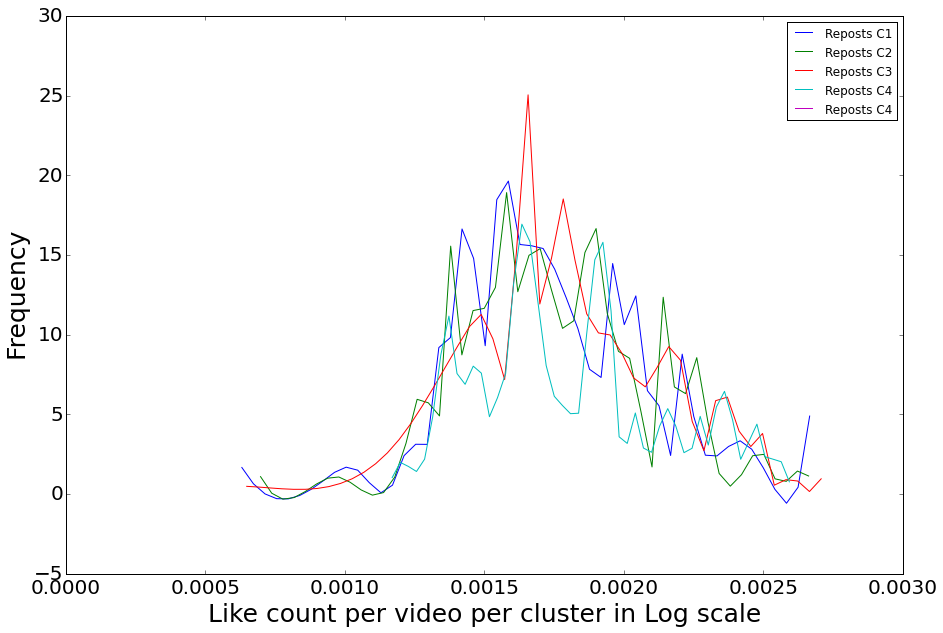

In [132]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plotDist(sampledLikesC1 , 200 , 50)
plotDist(sampledLikesC2 , 200 , 50)
plotDist(sampledLikesC3 , 200 , 50)
plotDist(sampledLikesC4 , 200 , 50)
plotDist(sampledLikesC5 , 200 , 50)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C4'])
plt.xlabel("Like count per video per cluster in Log scale",fontsize = 25)
plt.ylabel("Frequency ",fontsize = 25)
plt.show()

In [ ]:

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/50
# s = np.random.normal(size=N)   # generate your data sample with N elements
# p1, x1 = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
# p2, x2 = np.histogram(repostsC2, bins=n) # bin it into n = N/10 bins
# p3, x3 = np.histogram(repostsC3, bins=n) # bin it into n = N/10 bins
# p4, x4 = np.histogram(repostsC4, bins=n) # bin it into n = N/10 bins

# xs1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# xs2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# xs3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# xs4 = x4[:-1] + (x4[1] - x4[0])/2   # convert bin edges to centers

# f1 = UnivariateSpline(xs1, p1)
# f2 = UnivariateSpline(xs2, p2)
# f3 = UnivariateSpline(xs3, p3)
# f4 = UnivariateSpline(xs4, p4)

# plt.plot(xs1, f1(xs1) ,'.-')
# plt.plot(xs2, f2(xs2) ,'.-')
# plt.plot(xs3, f3(xs3) ,'.-')
# plt.plot(xs4, f4(xs4) ,'.-')

# plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4'])
# plt.show()

In [ ]:
# import numpy as np
# from scipy.interpolate import UnivariateSpline
# from matplotlib import pyplot as plt

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/10
# p, x1 = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
# p, x2 = np.histogram(repostsC2, bins=n) # bin it into n = N/10 bins
# p, x3 = np.histogram(repostsC3, bins=n) # bin it into n = N/10 bins
# x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# f = UnivariateSpline(x, p, s=n)
# plt.plot(x1, f(x1))
# plt.plot(x2, f(x2))
# plt.plot(x3, f(x3))
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/10
# p, x1 = np.histogram(likesC1, bins=n) # bin it into n = N/10 bins
# p, x2 = np.histogram(likesC2, bins=n) # bin it into n = N/10 bins
# p, x3 = np.histogram(likesC3, bins=n) # bin it into n = N/10 bins
# #x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# #x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# #x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# f = UnivariateSpline(x, p, s=n)
# plt.plot(x1, f(x1))
# plt.plot(x2, f(x2))
# plt.plot(x3, f(x3))
# plt.show()

In [ ]:
# from numpy import linspace,exp
# from numpy.random import randn
# import matplotlib.pyplot as plt
# from scipy.interpolate import UnivariateSpline
# x = linspace(-3, 3, 100)
# y = exp(-x**2) + randn(100)/10
# s = UnivariateSpline(x, y, s=1)
# xs = linspace(-3, 3, 1000)
# ys = s(xs)
# plt.plot(x, y, '.-')
# plt.plot(xs, ys)
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.hist(repostsC1, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
# plt.hist(repostsC2, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
# plt.hist(repostsC3, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# #plt.hist(repostsC4, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# plt.title("CDF for Reposts for the 4 sentiment clusters ", fontsize = 25)
# plt.xlabel("Repost count",fontsize = 25)
# plt.ylabel("CDF",fontsize = 25)
# plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4'])
# plt.show()

In [ ]:
# print np.std(repostsC1) , np.std(repostsC2), np.std(repostsC3), np.std(repostsC4)#, np.std(repostsC5)

# print np.std(likesC1) , np.std(likesC2), np.std(likesC3), np.std(likesC4)#, np.std(likesC5)

In [ ]:
# print senti_matrix[52]
# print postIdFilteredList[52]
# print filteredDict[postIdFilteredList[52]]
# print filteredPosts[postIdFilteredList[52]]

In [ ]:
import io
import base64
from IPython.display import HTML

num = 155
url = cluster4[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  cluster4[num]['videoDashUrl']
print ANP_cluster4[num]

#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].split('/')[1].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split(',')
        postId = components[0].split('/')[1].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            features.append(np.median(feats,0))
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [ ]:
with open(color_features) as g:
    featureLines = g.readlines()
print len(featureLines)

In [ ]:
featureLines[6].strip().split('|')[1:]

In [ ]:
features , posts = readFeatures(featureLines)

In [ ]:
print len(posts) , len(features)

In [ ]:
aes_features = np.asarray(features)
print aes_features.shape

In [ ]:
# aes_centroid_list = []
# aes_id_list = []
# for i in range(1 , 12):
#     centroids,_ = kmeans(aes_features,i)
#     idx,_ = vq(aes_features,centroids)
#     aes_centroid_list.append(centroids)
#     aes_id_list.append(idx)

In [ ]:

# SSE_values = np.zeros(len(aes_id_list))
# for i in range(len(aes_centroid_list)):
#     for j in range(len(aes_centroid_list[i])):
#         vecs = aes_features[aes_id_list[i]==j,:]
#         #print vecs.shape
#         cent = aes_centroid_list[i][j]
#         SSE_1 = 0.0
#         for vec in vecs:
#             SSE_1 = SSE_1 + minkowski(vec,cent,2)
#         SSE_values[j] = SSE_values[j] + SSE_1
# for i in range(len(SSE_values)):
#     SSE_values[i] = SSE_values[i]/(i+1)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 15)
# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20)
# x = np.arange(1,11)
# plt.plot(x,SSE_values[:10])
# plt.xlabel("Number of Clusters", fontsize = 25)
# plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
# plt.title("")
# plt.show()

In [ ]:
# aes_centroid_final,_ = kmeans(aes_features,4)
# aes_idx_final,_ = vq(aes_features,aes_centroid_final)

In [ ]:
# aes_cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,0)
# print len(aes_cluster1)
# aes_cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,1)
# print len(aes_cluster2)
# aes_cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,2)
# print len(aes_cluster3)
# aes_cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,3)
# print len(aes_cluster4)

In [ ]:
# import io
# import base64
# from IPython.display import HTML

# num = 50
# url = aes_cluster4[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
# print  aes_cluster4[num]['videoDashUrl']
# print ANP_cluster4[num]
# #print url
# videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
# #print videoPath


# video = io.open(videoPath, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))

In [ ]:
#print aes_centroid_final

In [ ]:

print cluster1[0]['postId']
print posts.index(str(cluster1[0]['postId']))

In [ ]:
def getAesFeatures(cluster, posts , numpyFeatures):
    indices = []
    for c in cluster:
        i = posts.index(str(c['postId']))
        if i:
            indices.append(i)
    features = numpyFeatures[indices]
    return features

In [ ]:
Aes1 = getAesFeatures(cluster1, posts , aes_features)
Aes2 = getAesFeatures(cluster2, posts , aes_features)
Aes3 = getAesFeatures(cluster3, posts , aes_features)
Aes4 = getAesFeatures(cluster4, posts , aes_features)
Aes5 = getAesFeatures(cluster5, posts , aes_features)

In [ ]:
print Aes1.shape
print Aes2.shape
print Aes3.shape
print Aes4.shape
print Aes5.shape

In [ ]:
# print Aes1

In [ ]:
plt.plot(Aes2[:,9])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plotDist(Aes1[:,10]/len(Aes1) , 1000 , 50)
plotDist(Aes2[:,10]/len(Aes2) , 1000 , 50)
plotDist(Aes3[:,10]/len(Aes3) , 1000 , 50)
plotDist(Aes4[:,10]/len(Aes4) , 1000 , 50)
plotDist(Aes5[:,10]/len(Aes5) , 1000 , 50)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C5'])
plt.show()